In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

fila_inicio = 1
#numero_filas = 90500  # Número de filas que deseas cargar
numero_filas = 120000
# Leer el CSV seleccionando el rango de filas específico
corrientes = pd.read_csv('corrientes.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_corrientes)
potencias = pd.read_csv('potencias.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_potencias)



# Convertir la columna 'timestamp' a datetime
corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute


#Codificación del tiempo del día
df_unido['tiempo_del_dia'] = df_unido['hora'] + df_unido['minuto'] / 60.0
df_unido['dia_sen'] = np.sin(2 * np.pi * df_unido['tiempo_del_dia'] / 24)
df_unido['dia_cos'] = np.cos(2 * np.pi * df_unido['tiempo_del_dia'] / 24)

# Codificación del día del año
df_unido['dia_del_año'] = df_unido['timestamp'].dt.dayofyear
df_unido['mes_sen'] = np.sin(2 * np.pi * df_unido['dia_del_año'] / 365)
df_unido['mes_cos'] = np.cos(2 * np.pi * df_unido['dia_del_año'] / 365)

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3','dia_sen','dia_cos', 'mes_sen', 'mes_cos']]


In [2]:
# Filtrar las filas donde el día sea igual a 1 (ya que día 0 no existe en un calendario)
df_dia_1 = final_df[final_df['dia'] == 1]

# Seleccionar solo la columna 'activa'
activa_dia_1 = df_dia_1['activa']

In [5]:
final_df = df_dia_1

In [2]:
import numpy as np

def add_noise_to_sequence(sequence, noise_level=0.1):
    """
    Adds Gaussian noise to a sequence of numerical data.

    Parameters:
    - sequence (np.array or list): The input sequence (e.g., a list of numbers or a numpy array).
    - noise_level (float): The standard deviation of the Gaussian noise to be added.
                           A higher value means more noise.

    Returns:
    - np.array: The sequence with added noise.
    """
    # Convert the input sequence to a numpy array if it isn't already
    sequence = np.array(sequence)
    
    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_level, size=sequence.shape)
    
    # Add the noise to the sequence
    noisy_sequence = sequence + noise
    
    return noisy_sequence

# Example usage
original_sequence = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
noisy_sequence = add_noise_to_sequence(original_sequence, noise_level=0.2)

print("Original Sequence:", original_sequence)
print("Noisy Sequence:", noisy_sequence)

Original Sequence: [1. 2. 3. 4. 5.]
Noisy Sequence: [1.24293495 2.09427472 2.99018921 4.19307099 4.406451  ]


In [6]:
final_df.shape

(3936, 15)

In [2]:
df_train = final_df[0:1500]
df_val = final_df[1501:3000]
df_test = final_df[3001:4006]

In [110]:
df_train.shape

(2000, 15)

In [6]:
df_train = df_dia_1[0:10000]
df_val = df_dia_1[10001:12500]
df_test = df_dia_1[125:140]

NameError: name 'df_dia_1' is not defined

In [8]:
print(df_val.shape)
print(df_train.shape)

(1499, 15)
(1500, 15)


In [31]:
#df_train = final_df[0:100]
#df_val = final_df[101:120]
#df_test = final_df[121:150]
# Repite esos 100 datos 10 veces
df_train = pd.concat([df_train] * 8, ignore_index=True)
df_val = pd.concat([df_train] * 1, ignore_index=True)
df_test = pd.concat([df_test] * 1, ignore_index=True)



In [38]:
import itertools

# Crear la secuencia base
secuencia_base = [1, 2, 0, 4, 5,-1,4]

# Usar itertools.cycle para repetir la secuencia
secuencia_repetida = list(itertools.islice(itertools.cycle(secuencia_base), 1500))

print(secuencia_repetida)

[1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 4, 5, -1, 4, 1, 2, 0, 

In [115]:
secuencia_aleatoria = np.random.randint(low=-5, high=6, size=1000)
secuencia_repetida = secuencia_aleatoria

In [93]:
train_secuencia = secuencia_repetida[0:600]
val_secuencia = secuencia_repetida[601:800]
test_secuencia = secuencia_repetida[801:1000]

NameError: name 'secuencia_repetida' is not defined

In [3]:
import numpy as np

def crear_ventana(dataset, ventana):
    X = []
    y = []

    # Crear ventanas y calcular el valor objetivo
    for i in range(len(dataset) - ventana):
        # Crear la ventana
        window = dataset.iloc[i:i+ventana].copy()

        # Características de la ventana
        window_features = window[['activa','dia_sen', 'dia_cos', 'mes_sen', 'mes_cos']].values
        
        # El valor objetivo es el valor de 'activa' en el tiempo t+1
        target_value = dataset.iloc[i+ventana]['activa']

        X.append(window_features)
        y.append(target_value)

    # Convertir las listas a arrays de NumPy para facilitar su uso
    X = np.array(X)
    y = np.array(y)
    #X = add_noise_to_sequence(X, noise_level=0.2)


    return X, y


In [7]:
def crear_ventana2(dataset, ventana):
    X = []
    y = []

    # Crear ventanas y calcular el valor objetivo
    for i in range(0, len(dataset) - ventana, ventana):
        # Crear la ventana
        window_features = dataset[i:i+ventana]

        # El valor objetivo es el valor en el tiempo t+1
        target_value = dataset[i+ventana]

        X.append(window_features)
        y.append(target_value)

    # Convertir las listas a arrays de NumPy para facilitar su uso
    X = np.array(X)
    y = np.array(y)

    return X, y

(995, 15)

In [4]:
t = 4
Xtrain, ytrain = crear_ventana(df_train, t)
Xval, yval = crear_ventana(df_val, t)
Xtest, ytest = crear_ventana(df_test, t)

In [13]:
from tensorflow.keras.models import load_model

# Cargar el modelo
modelo = load_model('best_model.h5')

# Usar el modelo cargado
predicciones = modelo.predict(Xtrain_n)
predicciones = salidas.inverse_transform(predicciones)

47/47 [==============================] - 17s 30ms/step


In [9]:
Xtrain.shape

(96, 4, 5)

In [11]:
print(df_val.shape)
print(df_train.shape)

print(Xval.shape)
print(Xtrain.shape)

(1499, 15)
(1500, 15)
(1495, 4, 5)
(1496, 4, 5)


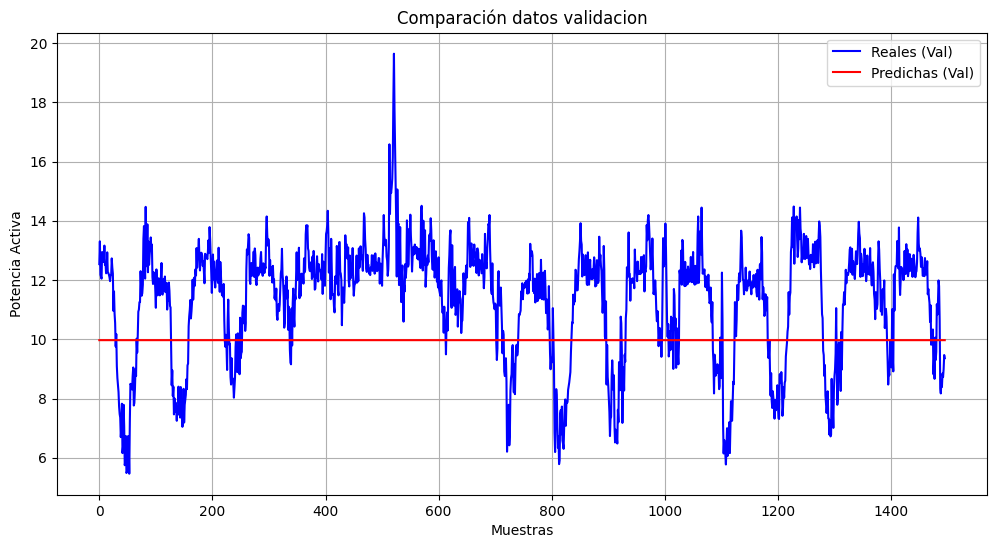

In [14]:
inicio = 00
fin = 150000

plt.figure(figsize=(12, 6))


# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytrain[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(predicciones[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
#plt.plot(ytest[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos validacion')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

In [13]:
t = 4*5
Xtrain_sec, ytrain_sec = crear_ventana2(train_secuencia, t)
Xval_sec, yval_sec = crear_ventana2(val_secuencia, t)
Xtest_sec, ytest_sec = crear_ventana2(test_secuencia, t)

NameError: name 'crear_ventana2' is not defined

In [118]:
Xtrain_sec

array([[ 2,  1,  2,  3,  3, -2, -5,  2, -5,  2,  2, -4,  2, -3,  5, -3,
        -4,  2, -1,  3],
       [ 4, -3,  4, -4,  0, -5,  4, -3, -5, -3, -4, -1, -2, -1,  0,  4,
         4,  1,  1, -4],
       [ 0, -2,  5,  4,  5,  3,  4, -1, -2,  0,  1, -1,  5, -2, -4,  5,
        -1, -1, -3, -3],
       [-5,  4,  5, -5, -4,  3, -1, -5,  3,  4,  5,  1,  1,  5,  4,  0,
        -3, -3,  4, -3],
       [ 3,  3,  0,  3, -5, -1, -1,  1,  2, -1,  3, -4,  2,  3,  4,  3,
         4,  1, -4,  2],
       [ 1, -5, -4,  4, -3, -3,  2,  3,  3,  5,  3,  1,  0,  5,  3,  1,
        -3, -2,  4,  5],
       [ 2, -1,  3, -3, -4, -3,  4, -4, -4,  1, -3, -4, -2,  4,  1,  3,
        -1,  1,  1,  4],
       [ 2,  1, -5,  5,  1, -5,  2,  3,  2,  1, -4,  0,  1,  1, -3, -2,
         4,  5,  0, -2],
       [-3,  1,  0, -5, -2,  0,  1,  2, -3,  3, -1,  3, -1,  0,  0,  0,
         4, -2,  2,  0],
       [ 5,  0,  1,  0, -5,  4,  2,  4, -1, -3,  0, -2, -4, -1,  1, -3,
         5, -3, -1,  4],
       [ 1, -4,  4,  5, -3, -3

In [48]:
Xtrain = Xtrain.astype('float32')
ytrain = ytrain.astype('float32')
yval = yval.astype('float32')
Xval = Xval.astype('float32')

In [6]:
Xtrain.dtype

dtype('float32')

In [7]:
Xtrain.shape

(996, 4, 5)

In [59]:
ytrain[1]

13.308

In [135]:
Xtrain[10,:,:]

array([[12.696     ,  0.60876143,  0.79335334,  0.01721336,  0.99985184],
       [12.684     ,  0.65934582,  0.75183981,  0.01721336,  0.99985184],
       [12.612     ,  0.70710678,  0.70710678,  0.01721336,  0.99985184],
       [13.164     ,  0.75183981,  0.65934582,  0.01721336,  0.99985184]])

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaleractiva = MinMaxScaler()
scalerreactiva = MinMaxScaler()
scaleraparente = MinMaxScaler()
scalercosdia = MinMaxScaler()
scalersendia = MinMaxScaler()
scalercoshora = MinMaxScaler()
scalersenhora = MinMaxScaler()
scalerl1 = MinMaxScaler()
scalerl2 = MinMaxScaler()
scalerl3 = MinMaxScaler()
scalermedia = MinMaxScaler()
scalervar = MinMaxScaler()
scalerdesv = MinMaxScaler()
salidas = MinMaxScaler()
diferencias = MinMaxScaler()
#final_df = final_df[['activa', 'aparente', 'reactiva', 'l1', 'l2', 'l3','dia_sen','dia_cos', 'mes_sen', 'mes_cos']]

Xtrain_n = Xtrain.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xtrain_n[:, :, 0] = scaleractiva.fit_transform(Xtrain[:, :, 0])
Xtrain_n[:, :, 1] = scalersenhora.fit_transform(Xtrain[:, :, 1])
Xtrain_n[:, :, 2] = scalercoshora.fit_transform(Xtrain[:, :, 2])
Xtrain_n[:, :, 3] = scalersendia.fit_transform(Xtrain[:, :, 3])
Xtrain_n[:, :, 4] = scalercosdia.fit_transform(Xtrain[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [9]:

Xval_n = Xval.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xval_n[:, :, 0] = scaleractiva.transform(Xval[:, :, 0])
Xval_n[:, :, 1] = scalersenhora.transform(Xval[:, :, 1])
Xval_n[:, :, 2] = scalercoshora.transform(Xval[:, :, 2])
Xval_n[:, :, 3] = scalersendia.transform(Xval[:, :, 3])
Xval_n[:, :, 4] = scalercosdia.transform(Xval[:, :, 4])
#X_n[:, :, 1] = scaleraparente.fit_transform(X[:, :, 1])
#X_n[:, :, 2] = scalerreactiva.fit_transform(X[:, :, 2])
#X_n[:, :, 3] = scalerl1.fit_transform(X[:, :, 3])
#X_n[:, :, 4] = scalerl2.fit_transform(X[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [10]:

Xtest_n = Xtest.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xtest_n[:, :, 0] = scaleractiva.transform(Xtest[:, :, 0])
Xtest_n[:, :, 1] = scalersenhora.transform(Xtest[:, :, 1])
Xtest_n[:, :, 2] = scalercoshora.transform(Xtest[:, :, 2])
Xtest_n[:, :, 3] = scalersendia.transform(Xtest[:, :, 3])
Xtest_n[:, :, 4] = scalercosdia.transform(Xtest[:, :, 4])
#X_n[:, :, 1] = scaleraparente.fit_transform(X[:, :, 1])
#X_n[:, :, 2] = scalerreactiva.fit_transform(X[:, :, 2])
#X_n[:, :, 3] = scalerl1.fit_transform(X[:, :, 3])
#X_n[:, :, 4] = scalerl2.fit_transform(X[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [11]:
ytest = ytest.reshape(-1,1)
ytrain = ytrain.reshape(-1,1)
yval = yval.reshape(-1,1)



ytest_n = ytest.copy()
ytrain_n = ytrain.copy()
yval_n = yval.copy()


ytrain_n = salidas.fit_transform(ytrain)
yval_n = salidas.transform(yval)
ytest_n = salidas.transform(ytest)



In [12]:
ytrain_sec.shape

NameError: name 'ytrain_sec' is not defined

In [180]:
Xtrain_sec = Xtrain_sec.reshape(Xtrain_sec.shape[0],Xtrain_sec.shape[1],1)
Xval_sec = Xval_sec.reshape(Xval_sec.shape[0],Xval_sec.shape[1],1)
Xtest_sec = Xtest_sec.reshape(Xtest_sec.shape[0],Xtest_sec.shape[1],1)

ytrain_sec = ytrain_sec.reshape(-1,1)
yval_sec = yval_sec.reshape(-1,1)
ytest_sec = ytest_sec.reshape(-1,1)

NameError: name 'Xtrain_sec' is not defined

In [12]:
print(Xtrain_n.shape)
print(Xval_n.shape)
print(Xtest_n.shape)
print(yval_n.shape)
print(ytest_n.shape)
print(yval_n.shape)

(1496, 4, 5)
(1495, 4, 5)
(1001, 4, 5)
(1495, 1)
(1001, 1)
(1495, 1)


In [14]:
Xtrain_sec.shape

(37, 4, 1)

In [120]:
Xtrain_sec = Xtrain_sec.astype('float32')
ytrain_sec = ytrain_sec.astype('float32')

Epoch 1/150
47/47 [==============================] - 34s 162ms/step - loss: 0.3414 - val_loss: 0.0400
Epoch 2/150
 1/47 [..............................] - ETA: 1s - loss: 0.0720

C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 2s 49ms/step - loss: 0.0815 - val_loss: 0.0357
Epoch 3/150
47/47 [==============================] - 2s 47ms/step - loss: 0.0795 - val_loss: 0.0364
Epoch 4/150
47/47 [==============================] - 3s 55ms/step - loss: 0.0773 - val_loss: 0.0278
Epoch 5/150
47/47 [==============================] - 3s 55ms/step - loss: 0.0734 - val_loss: 0.0207
Epoch 6/150
47/47 [==============================] - 2s 53ms/step - loss: 0.0696 - val_loss: 0.0183
Epoch 7/150
47/47 [==============================] - 3s 55ms/step - loss: 0.0676 - val_loss: 0.0180
Epoch 8/150
47/47 [==============================] - 3s 54ms/step - loss: 0.0698 - val_loss: 0.0160
Epoch 9/150
47/47 [==============================] - 3s 54ms/step - loss: 0.0658 - val_loss: 0.0155
Epoch 10/150
47/47 [==============================] - 2s 49ms/step - loss: 0.0648 - val_loss: 0.0154
Epoch 11/150
47/47 [==============================] - 2s 44ms/step - loss: 0.0660 - val_loss: 0.0157
Epoch 12/1

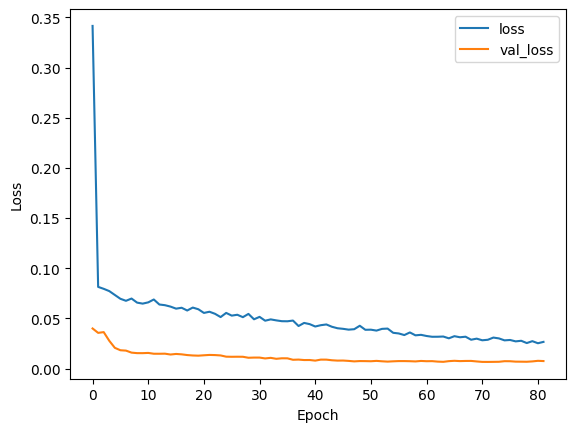

In [15]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import RMSprop

# Asegurar reproducibilidad
np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

# Define los intervalos y los valores de learning rate
boundaries = [9, 12, 15, 25, 40, 60]  # Los límites de los intervalos (épocas en este caso)
values = [0.02, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]  # Learning rates correspondientes a los intervalos

# Crea el scheduler de learning rate
lr_schedule = PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)


model = Sequential()

model.add(LSTM(55, return_sequences=    True, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(55, return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(55, return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(55, return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(55, return_sequences=True, kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(55, return_sequences=False, kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(1, kernel_initializer=initializer, activation='linear'))

# Compilar el modelo con el optimizador personalizado
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1)
model.compile(optimizer=optimizer, loss='mse')

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo con datos de validación y EarlyStopping
history = model.fit(Xtrain_n, ytrain_n, epochs=150, verbose=1, batch_size=32,
                    validation_data=(Xval_n, yval_n), callbacks=[early_stopping, model_checkpoint])

# Graficar la curva de entrenamiento y validación
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [184]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.initializers import GlorotUniform

# Asegurar reproducibilidad
np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

# Define los intervalos y los valores de learning rate
boundaries = [5, 10, 15, 20, 35, 50]  # Límites de los intervalos (épocas en este caso)
values = [0.02, 0.025, 0.005, 0.001, 0.0005, 0.0001, 0.00005]  # Learning rates correspondientes a los intervalos

# Crear el scheduler de learning rate
lr_schedule = PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)

# Crear el modelo LSTM
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape, kernel_initializer=initializer))
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer=initializer, activation='linear'))
    optimizer = Adam(learning_rate=lr_schedule, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Inicializar el modelo
input_shape = (Xtrain_n.shape[1], Xtrain_n.shape[2])
model = create_model(input_shape)

# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Ciclo para simular la llegada de nuevos datos
num_iterations = 1000  # Número de iteraciones de entrenamiento
initial_train_size = 500  # Tamaño inicial del conjunto de entrenamiento
increment_size = 1  # Cantidad de muestras nuevas agregadas en cada iteración

# Crear copias de los datos para preservarlos
Xtrain_copy = Xtrain_n.copy()
ytrain_copy = ytrain_n.copy()
Xval_copy = Xval_n.copy()
yval_copy = yval_n.copy()

# Inicializar el conjunto de entrenamiento con un tamaño inicial
Xtrain_current = Xtrain_copy[:initial_train_size]
ytrain_current = ytrain_copy[:initial_train_size]

for i in range(num_iterations):
    print(f"Iteración {i+1}/{num_iterations}")
    
    # Comprobar que hay suficientes datos en los conjuntos de entrenamiento y validación
    if Xtrain_current.shape[0] == 0 or ytrain_current.shape[0] == 0:
        print("No hay suficientes datos de entrenamiento. Finalizando entrenamiento.")
        break
    
    validation_data = (Xval_copy, yval_copy) if Xval_copy.shape[0] > 0 and yval_copy.shape[0] > 0 else None
    
    # Entrenar el modelo
    model.fit(Xtrain_current, ytrain_current, epochs=1, verbose=1, batch_size=1,
              validation_data=validation_data, callbacks=[early_stopping])

    # Simular la llegada de nuevos datos
    if i < num_iterations - 1:
        next_batch_size = min(increment_size, len(Xtrain_copy) - len(Xtrain_current))
        if next_batch_size > 0:
            Xtrain_current = np.concatenate((Xtrain_current, Xtrain_copy[len(Xtrain_current):len(Xtrain_current) + next_batch_size]), axis=0)
            ytrain_current = np.concatenate((ytrain_current, ytrain_copy[len(ytrain_current):len(ytrain_current) + next_batch_size]), axis=0)


Iteración 1/1000
500/500 [==============================] - 7s 10ms/step - loss: 0.0138 - val_loss: 0.4164
Iteración 2/1000
501/501 [==============================] - 4s 9ms/step - loss: 0.0102 - val_loss: 0.3420
Iteración 3/1000
502/502 [==============================] - 5s 9ms/step - loss: 0.0099 - val_loss: 0.2512
Iteración 4/1000
503/503 [==============================] - 5s 9ms/step - loss: 0.0088 - val_loss: 0.1840
Iteración 5/1000
504/504 [==============================] - 5s 9ms/step - loss: 0.0080 - val_loss: 0.1243
Iteración 6/1000
505/505 [==============================] - 4s 9ms/step - loss: 0.0072 - val_loss: 0.0728
Iteración 7/1000
506/506 [==============================] - 4s 9ms/step - loss: 0.0063 - val_loss: 0.0395
Iteración 8/1000
507/507 [==============================] - 5s 9ms/step - loss: 0.0054 - val_loss: 0.0202
Iteración 9/1000
508/508 [==============================] - 5s 9ms/step - loss: 0.0051 - val_loss: 0.0123
Iteración 10/1000
509/509 [==================

In [118]:
Xtrain.shape

(1996, 4, 5)

In [31]:
a = model.predict(Xtrain)[0, 0] 
a

32/32 [==============================] - 1s 3ms/step


array([1.126486], dtype=float32)

In [16]:
Xtrain_sec[0]

NameError: name 'Xtrain_sec' is not defined

In [106]:
#1, 2, 0, 4, 5, 1, 2, 0, 4, 5
a = model.predict(Xtrain_sec)[0, 0] 
a

1/1 [==============================] - 1s 1s/step


2.065076

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Supongamos que tienes Xtrain, ytrain y el modelo ya entrenado
num_samples = Xtrain.shape[0]
y_pred = np.zeros(num_samples)  # Array para guardar predicciones

for i in range(num_samples):
    x_sample = Xtrain_n[i:i+1]  # Selecciona el i-ésimo ejemplo
    y_pred[i] = model.predict(x_sample)[0, 0]  # Predicción para el ejemplo i

y_pred = y_pred.reshape(-1,1)
y_pred = salidas.inverse_transform(y_pred)
y_pred = y_pred.flatten()
# Calcular errores
errors = ytrain.flatten() - y_pred
mse = mean_squared_error(ytrain, y_pred)
print("MSE en el conjunto de entrenamiento:", mse)

# Crear un DataFrame para almacenar resultados
results = pd.DataFrame({
    'Valor Real': ytrain.flatten(),
    'Predicción': y_pred.flatten(),
    'Error': errors
})

# Guardar en un archivo CSV
results.to_csv('resultados_predicciones.csv', index=False)

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(results['Valor Real'], label='Valor Real', alpha=0.7)
plt.plot(results['Predicción'], label='Predicción', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results['Error'], label='Error de Predicción', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Error')
plt.title('Error de Predicción')
plt.legend()
plt.show()

1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: 

In [65]:
Xval_n.shape

(0,)

In [16]:
prediccionesval = model.predict(Xval_n)
prediccionestest = model.predict(Xtest_n)
#prediccionesval = prediccionesval.reshape(-1,1)
#prediccionestest= prediccionestest.reshape(-1,1)

prediccionesval = salidas.inverse_transform(prediccionesval)
prediccionestest = salidas.inverse_transform(prediccionestest)

32/32 [==============================] - 0s 12ms/step


In [103]:
prediccionesvalsec = model.predict(Xval_sec)
prediccionestestsec = model.predict(Xtest_sec)

NameError: name 'Xval_sec' is not defined

In [78]:
prediccionestest.shape

(395, 1)

In [23]:

# Supongamos que tienes datos de prueba Xtest y ytest

plt.figure(figsize=(12, 6))
plt.plot(yval_sec.flatten()[0:100], label='Valores Reales')
plt.plot(prediccionesvalsec.flatten()[0:100], label='Predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

NameError: name 'yval_sec' is not defined

<Figure size 1200x600 with 0 Axes>

In [45]:
Xval.shape

(9996, 4, 5)

In [79]:
yval = yval.reshape(-1,1)

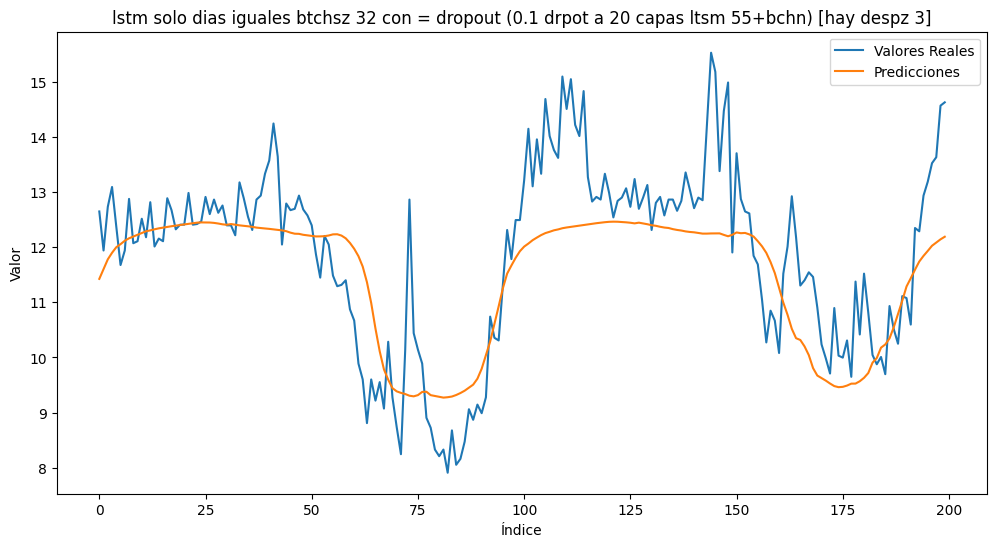

In [17]:

# Supongamos que tienes datos de prueba Xtest y ytest

plt.figure(figsize=(12, 6))
plt.plot(yval[100:300], label='Valores Reales')
plt.plot(prediccionesval[100:300], label='Predicciones')
plt.title("lstm solo dias iguales btchsz 32 con = dropout (0.1 drpot a 20 capas ltsm 55+bchn) [hay despz 3]")
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

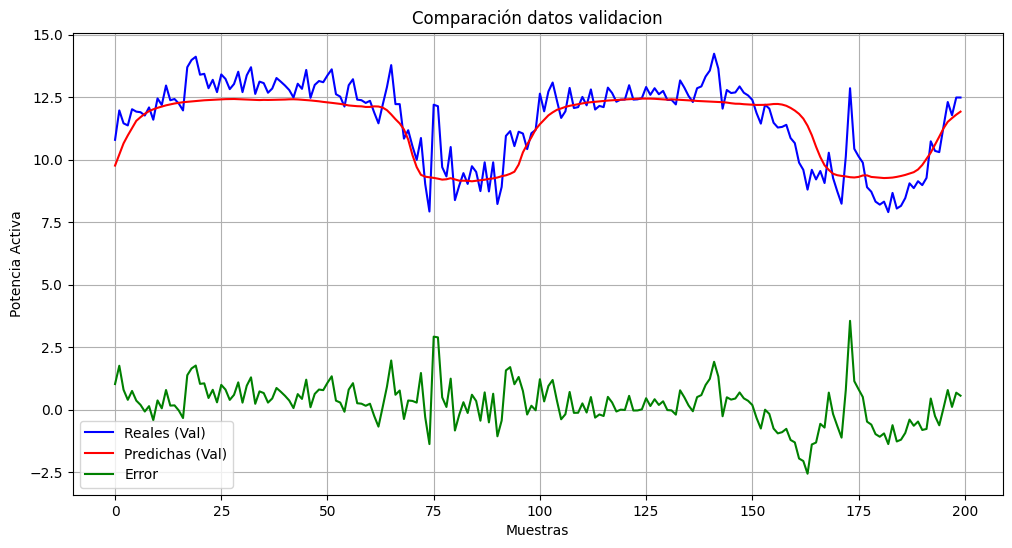

In [18]:
inicio = 00
fin = 200

plt.figure(figsize=(12, 6))
error = yval - prediccionesval

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(yval[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionesval[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos validacion')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


In [117]:
Xtrain.shape

(4900, 100, 5)

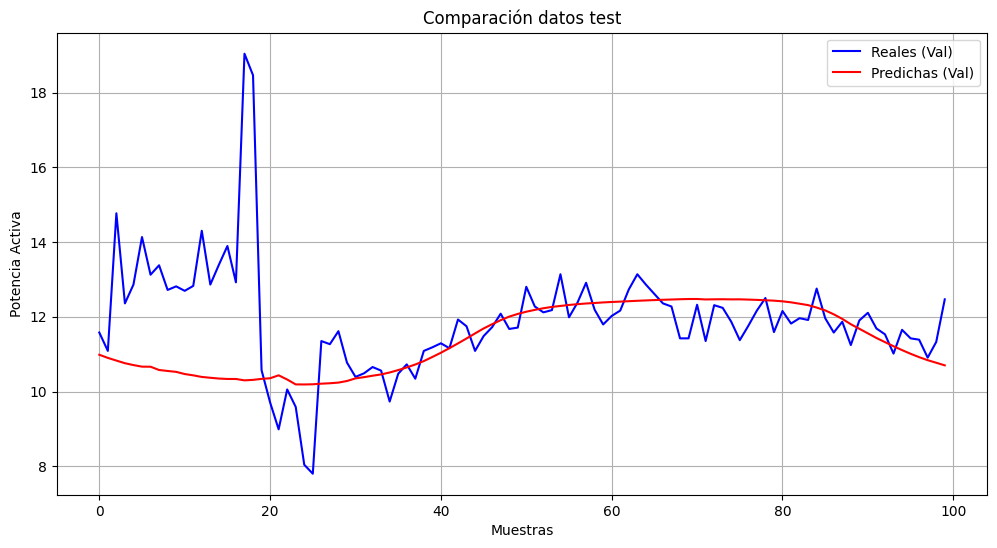

In [20]:
inicio = 000
fin = 100

plt.figure(figsize=(12, 6))
prediccionestest = prediccionestest.reshape(-1,1)
ytest = ytest.reshape(-1,1)
error = ytest - prediccionestest

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytest[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestest[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
#plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos test')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


In [36]:
prediccionestest_desn = salidas.inverse_transform(prediccionestest)
prediccionesval_desn = salidas.inverse_transform(prediccionesval)

In [21]:
inicio = 00
fin = 3300

plt.figure(figsize=(12, 6))
error = yval - prediccionesval_desn

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(yval[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionesval_desn[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos validacion')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


NameError: name 'prediccionesval_desn' is not defined

<Figure size 1200x600 with 0 Axes>

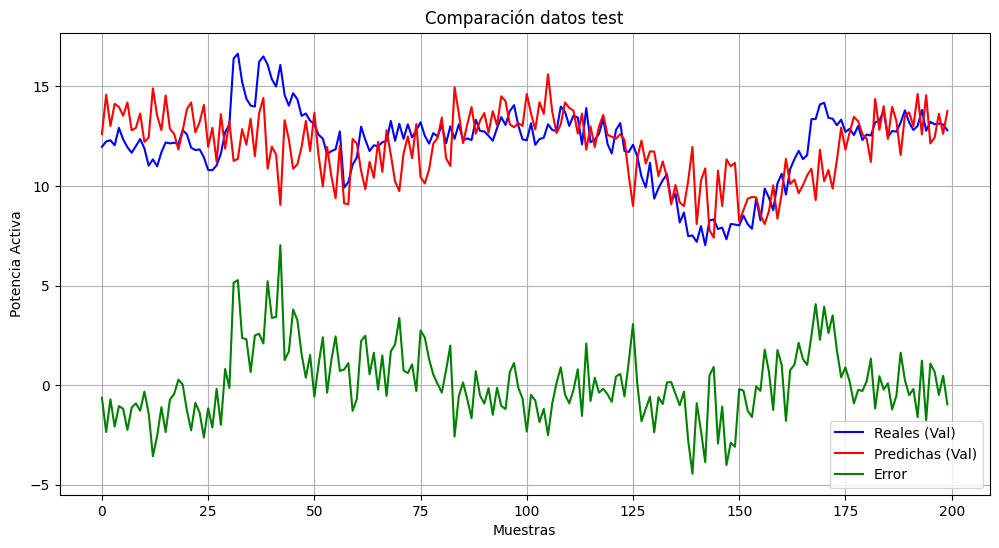

In [150]:
inicio = 000
fin = 200

plt.figure(figsize=(12, 6))
error = ytest - prediccionestest_desn

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytest[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestest_desn[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos test')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

In [56]:
Xtrain_n.shape

(996, 4, 5)

In [22]:
prediccionestrain = model.predict(Xtrain_n)
#prediccionestrain = salidas.inverse_transform(prediccionestrain)

47/47 [==============================] - 1s 12ms/step


In [63]:
prediccionestrain.shape

(996, 4, 1)

In [17]:
a =model.evaluate(Xtrain_n)

NameError: name 'Xtrain_n' is not defined

(96, 4, 5)

In [24]:
prediccionestrain = prediccionestrain.reshape(-1,1)
prediccionestrain = salidas.inverse_transform(prediccionestrain)

In [18]:
ytrain = ytrain.reshape(-1,1)

In [26]:
ytrain[1:100]

array([[13.308],
       [12.18 ],
       [12.12 ],
       [12.048],
       [12.948],
       [12.696],
       [12.684],
       [12.612],
       [13.164],
       [12.516],
       [12.564],
       [12.228],
       [12.276],
       [12.936],
       [12.264],
       [12.24 ],
       [12.18 ],
       [12.096],
       [11.964],
       [12.168],
       [12.168],
       [12.732],
       [12.42 ],
       [12.216],
       [10.956],
       [11.616],
       [10.872],
       [10.548],
       [ 9.756],
       [10.176],
       [ 9.096],
       [ 8.688],
       [ 8.46 ],
       [ 8.22 ],
       [ 7.728],
       [ 7.476],
       [ 7.356],
       [ 6.696],
       [ 7.02 ],
       [ 7.824],
       [ 6.156],
       [ 6.372],
       [ 7.788],
       [ 7.056],
       [ 5.748],
       [ 5.868],
       [ 6.732],
       [ 5.484],
       [ 5.532],
       [ 6.024],
       [ 6.732],
       [ 6.408],
       [ 5.46 ],
       [ 7.212],
       [ 8.496],
       [ 8.46 ],
       [ 8.436],
       [ 8.304],
       [ 8.76 

In [133]:
prediccionesval = prediccionesval.reshape(-1,1)

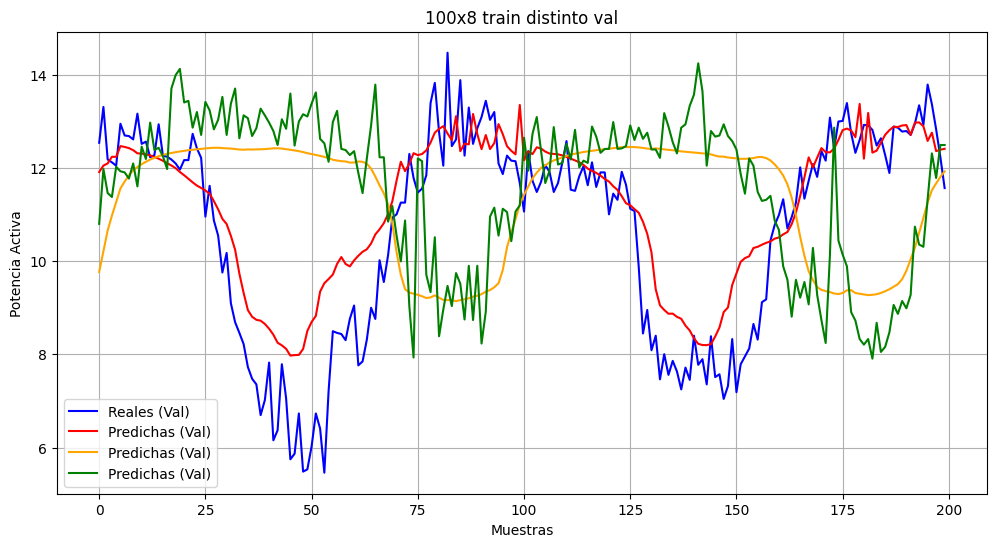

In [25]:
inicio =00
fin = 200

plt.figure(figsize=(12, 6))
#error = ytrain - prediccionestrain

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytrain[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestrain[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(prediccionesval[inicio:fin], label='Predichas (Val)', linestyle='-', color='orange')
plt.plot(yval[inicio:fin], label='Predichas (Val)', linestyle='-', color='green')

#plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('100x8 train distinto val')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

In [2]:
# Leer los CSV a partir de la fila 117207 (recordar que skiprows es 0-based)

# Leer los encabezados del archivo
encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

#corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
#potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
#fila_inicio = 117206  # Índice de la primera fila que deseas cargar
fila_inicio = 500
numero_filas = 4149  # Número de filas que deseas cargar

# Leer el CSV seleccionando el rango de filas específico
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_corrientes)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_potencias)



# Convertir la columna 'timestamp' a datetime
corrientes_nuevas['timestamp'] = pd.to_datetime(corrientes_nuevas['timestamp'])
potencias_nuevas['timestamp'] = pd.to_datetime(potencias_nuevas['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes_nuevas, potencias_nuevas, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
df_nuevo = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(df_nuevo)

NameError: name 'pd' is not defined

In [ ]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
     # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        # forecast sequence (t, t+1, .
        cols.append(df.shift(-i))
        # put it all together
        agg = concat(cols, axis=1)
        # drop rows with NaN values
        agg.dropna(inplace=True)
    return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
# prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
    n_input, _, _, _, n_diff = config
# prepare data
correction = 0.0
if n_diff > 0:
correction = history[-n_diff]
history = difference(history, n_diff)
x_input = array(history[-n_input:]).reshape((1, n_input, 1))
# forecast
yhat = model.predict(x_input, verbose=0)
return correction + yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
scores_m, score_std = mean(scores), std(scores)
print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
pyplot.boxplot(scores)
pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)


In [26]:
import joblib
# Diccionario que contiene el modelo y los escaladores
model_and_scalers = {
    'model': model,
    'scaleractiva': scaleractiva,
    'scalercosdia': scalercosdia,
    'scalercoshora': scalercoshora,
    'scalersendia': scalersendia,
    'scalersenhora': scalersenhora,
    'scaler_y': salidas
}

# Guardar el diccionario con joblib
joblib.dump(model_and_scalers, 'model_and_scalers.pkl')

['model_and_scalers.pkl']

In [27]:

# Cargar el diccionario guardado
loaded_data = joblib.load('model_and_scalers.pkl')

# Recupera el modelo y los escaladores
model = loaded_data['model']
scaler_X = loaded_data['scaler_X']
scaler_y = loaded_data['scaler_y']

# Escala los datos de entrada antes de predecir
X_test_scaled = scaler_X.transform(X_test)
y_pred_scaled = model.predict(X_test_scaled)

# Inversa de la escala para obtener la predicción original
y_pred = scaler_y.inverse_transform(y_pred_scaled)

KeyError: 'scaler_X'